# Necessary packages and functions

In [14]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib as mpl
import itertools
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.gaussian_process import GaussianProcessClassifier as GPC
from sklearn.gaussian_process.kernels import RBF, Matern, WhiteKernel, DotProduct
from sklearn.ensemble import AdaBoostClassifier as ABC
from sklearn.ensemble import GradientBoostingClassifier as GBC
from sklearn import preprocessing
from sklearn.tree import DecisionTreeClassifier as DTC
from sklearn.neighbors import KNeighborsClassifier as KNC
from sklearn.calibration import CalibratedClassifierCV as CCCV
from scipy.stats import mode

import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import multivariate_normal
from tqdm import tqdm_notebook as tqdm

import torch
import torch.nn as nn
import torch.optim as optim 
import torchbnn as bnn
from torch.utils.data import DataLoader, TensorDataset

def set_plot_defaults(): 
    """Sets up default plotting values for our figures
    """
    mpl.rcdefaults()
    plt.rc('axes', labelsize=20)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=20)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=20)    # fontsize of the tick labels
    plt.rc('legend', fontsize=20)    # legend fontsize
    plt.rc('figure', titlesize=20)  # fontsize of the figure title
    plt.rc('legend', frameon = False) #don't add a box around legends
    plt.rc('lines', linewidth = 4) #make lines thick enough to see 
    plt.rc('axes', titlesize = 30) #make titles big enough to read

def RR(labels, epsilon): 
    #apply randomized response to labels 
    k = len(np.unique(labels))
    prob_flip = (k-1) / (np.exp(epsilon) + (k-1))
    print('prob of flip:', prob_flip)
    flip_idx = np.random.binomial(1, prob_flip, len(labels)) == 1
    comp_idx = np.asarray([[True]*k]*len(labels))
    comp_idx[np.arange(len(labels))[:,None],labels] = False
    comp = np.tile(np.arange(k), [len(labels), 1])
    comp = np.reshape(comp[comp_idx], (len(labels), k-1))
    choices = np.random.choice(np.arange(k-1), len(labels))
    randsamp = comp[np.arange(len(labels)), choices]
    labels_z = labels.copy()
    labels_z[flip_idx] = randsamp[:,None][flip_idx]
    return labels_z
  
def kNN_pred(Y, Dmat, N, i, K): 
    neighb_idx = N[i,:]
    m = np.sum(neighb_idx)
    if K > m: #don't let the NN prediction be larger than the group 
        K = m
    neighb_ids = np.where(neighb_idx)[0]
    neighb_dists = Dmat[i, neighb_ids]
    NNs = neighb_ids[np.argsort(neighb_dists)[:K]]
    kNN_pred_trials = mode(Y[NNs,:].astype(int), axis = 0)[0]
    #returns kNN prediction on i for each of the ldp trials Y
    return kNN_pred_trials
  
def k_vs_grp_attack(X, Y, Dmat, Distmat, R, Rcorr, K = 20, t = 0.9):
    N = Distmat <= R #neighborhood of group
    Ncorr = Distmat <= Rcorr #neighborhood for correlating 
    
    n = len(X)
    vulnerable_k = [] #list of ids that can be inferred by K
    vulnerable_grp = [] #list of ids that can be inferred by grp 

    for i in range(n):
        m = N[i,:].sum() #num neighbors

        K_preds = kNN_pred(Y, Dmat, Ncorr, i, K) #prediction by K NN's for each Y trial
        K_pred_acc = np.mean(K_preds == X[i]) #accuracy across trials
        if K_pred_acc >= t: 
            vulnerable_k.append(i)

        grp_preds = kNN_pred(Y, Dmat, N, i, K = m) #prediction by whole group for each Y trial
        grp_pred_acc = np.mean(grp_preds == X[i]) #accuracy across trials
        if grp_pred_acc >= t: 
            vulnerable_grp.append(i)
            
    return vulnerable_k, vulnerable_grp
  
  
def knn_attack(T_i, T_neighb, Y_neighb, K=10):

    feat_idxs = [
      T_cols == 'PAT_AGE',
      T_cols == 'TOTAL_CHARGES',
      T_cols == 'ADMIT_WEEKDAY',
      T_cols == 'LENGTH_OF_STAY',
      (T_cols == 'KM_LAT')|(T_cols == 'KM_LON'),
      (T_cols == 'TYPE_OF_ADMISSION_1') | (T_cols == 'TYPE_OF_ADMISSION_2') |
      (T_cols == 'TYPE_OF_ADMISSION_3') | (T_cols == 'TYPE_OF_ADMISSION_5'),
      (T_cols == 'SEX_CODE_F') | (T_cols == 'SEX_CODE_M')
      ]
    feat_names = [
      'age',
      'charges',
      'weekday',
      'length of stay',  
      'location',  
      'type of admission',
      'gender'
    ]
    
    if T_neighb.shape[0] < K: 
        K = T_neighb.shape[0]

    #make prediction for each feature KNN clf 
    predictions = np.zeros(len(feat_idxs) + 1, dtype = int)
        
    for i in range(len(feat_idxs)): 
        clf = KNC(n_neighbors=K) #NN model 
        clf.fit(T_neighb[:,feat_idxs[i]], Y_neighb)
        predictions[i] = clf.predict(T_i[feat_idxs[i]][None, :])

    #make ensemble prediction: 
    predictions[-1] = np.argmax(np.bincount(predictions))
    
    return predictions

  
def shuffle_dataset(labels, alpha, Deltas, sig0): 
    labels_shuff = np.zeros(len(labels))
    for sig0_, Delta in zip(sig0, Deltas): 
        labels_ = labels[sig0_]
        if Delta > 1: 
            theta = 2 * alpha / (Delta * (Delta - 1))
            shff_ = shuffle_graph(labels_, theta, np.argsort(np.argsort(sig0_)))
        else: 
            shff_ = labels_
      
        labels_shuff[sig0_] = shff_.squeeze()
    return labels_shuff
  
def shuffle_dataset_II(labels, alpha, Deltas, sig0): 
    sig_full = []
    sig0_full = []
    for sig0_, Delta in zip(sig0, Deltas): 
        if Delta > 1: 
            theta = 2 * alpha / (Delta * (Delta - 1))
            sig_full = np.concatenate((sig_full, mallows(theta = theta, sig0 = sig0_)))
        else: 
            sig_full = np.concatenate((sig_full, sig0_))
            
        sig0_full = np.concatenate((sig0_full, sig0_))
      
    sig_full = sig_full.astype(int)
    sig0_full = sig0_full.astype(int)
    labels_shuff = labels[sig_full[np.argsort(sig0_full)]]
    return labels_shuff, sig_full, sig0_full
    
def shuffle_graph(labels, theta = 0, sig0_ = np.array([])): 
    n_pts = len(labels)
    if sig0_.size == 0: 
        sig0_ = np.arange(n_pts)
    sig = mallows(theta = theta, sig0 = sig0_)[np.argsort(sig0_)]
    return labels[sig]
  
def mallows(theta, sig0 = []): 
  if len(sig0) == 0: 
    print('need a reference permutation')
    return
#   N = len(sig0) * (len(sig0) - 1) / 2
#   if alpha > 0:
#     theta = alpha / N
#   print('theta is', theta)
  phi = np.exp(-theta)
  #get insertion probabilities 
  ws = []
  ct = 0
  for i in range(len(sig0)): 
    wi_ = []
    #formula is given with index by 1
    i = i+1
    for j in range(i): 
      j = j+1
      wij = phi**(i-j) * (1 - phi) / (1 - phi**i)
      wi_.append(wij)
      ct += 1
    ws.append(wi_)

  # sample from these ws 
  inserts = []
  for i in range(len(sig0)): 
    #to ensure sum to 1
    p_vals = ws[i] / np.sum(ws[i])
    chosen_wij = np.random.choice(len(ws[i]), p = p_vals)
    inserts.append(chosen_wij)
    
  #build the sampled permutation 
  pi = np.empty(0, dtype = int)
  for i in range(len(sig0)): 
    pi = np.insert(pi, inserts[i], sig0[i])

  return pi

def get_sig0(T, R, Distmat, Distmat_corrs): 
    N = Distmat <= R
    most_neighbs = np.max(np.sum(N, axis = 1))
    print('most neighbs:', most_neighbs)
    sig0 = []
    n = N.shape[0]

    # Visited vector 
    visited = [False] * int(n)

    start = np.argmax(N.sum(axis = 1)) #start at node with largest group

    while np.sum([len(sig0_) for sig0_ in sig0]) < n: 
        # Set source as visited 
        visited[start] = True
        q = [start] 
        # Start a new sig0 for this graph: 
        sig0_ = []
        while q: 
            vis = q[0] 

            # Print current node 
            sig0_.append(vis)
            q.pop(0) 

            # Get every adjacent vertex to  
            # the current vertex 
            neighbs = np.nonzero(N[vis,:])[0]
            new_neighbs = neighbs[~np.in1d(neighbs, np.nonzero(visited)[0])]
            if new_neighbs.any(): 
                # Sort unvisited neighbors by closest distance to the current vertex 
                dists = Distmat_corrs[vis, new_neighbs]
#                 corrs = kernel(T[vis,:], T[new_neighbs,:]).squeeze()
                dist_order = np.argsort(dists)
#                 corr_order = np.argsort(corrs)[::-1]
                new_neighbs = new_neighbs[dist_order] 
                for neighb in new_neighbs: 
                    # Push the adjacent node  
                    # in the queue 
                    q.append(neighb) 
                    # set 
                    visited[neighb] = True
        #if q finishes but haven't visited everyone, then we start a new graph
        sig0.append(sig0_)
        if np.concatenate(sig0).size < n: 
            start = np.argmax(~np.asarray(visited)) #get first non-visited index 

    Deltas = [] #records Delta for each subgraph 
    for sig0_ in sig0: 
        if np.size(sig0_) > 1: 
            deltas = []
            for k in range(len(sig0_)): 
                neighbs = np.nonzero(N[sig0_[k],:])[0]
                neighbs_idx = np.where(np.in1d(sig0_, neighbs))[0]
                newdelt = (np.max(neighbs_idx ) - np.min(neighbs_idx)) + 1
                deltas.append(newdelt)
            Deltas.append(np.max(deltas))
        else: 
            Deltas.append(1)
    return sig0, Deltas
  
def county_error(labels, T, T_cols, X): 
    cnty = T_cols == 'COUNTY'
    counties = np.unique(T[:,cnty])
    count_diffs = []
    for county in counties: 
        cnty_idx = (T[:,cnty] == county).squeeze()
        label_cts = np.zeros(4)
        label_cty = labels[cnty_idx]
        label_bcts = np.bincount(label_cty.astype(int))
        label_cts[0:len(label_bcts)] = label_bcts

        true_cts = np.zeros(4)
        true_cty = X[cnty_idx]
        true_bcts = np.bincount(true_cty.astype(int))
        true_cts[0:len(true_bcts)] = true_bcts

        count_diffs.append( np.abs(label_cts - true_cts).sum()/np.sum(true_cts) )
        
    return np.asarray(count_diffs)
  
def get_calibration_TVD(y_vals, x_vals, Distmat, R_calib, T_locat, cv,
                        base_clf = RFC()):
    #Train calib model on noisy data, and predict
#     base_clf = RFC(min_samples_leaf=min_samples_leaf)
    calib = CCCV(base_estimator=base_clf, cv=cv)
    calib.fit(T_locat, y_vals)
    calib_hists = calib.predict_proba(T_locat)

#     #Get calibration neighbors 
#     N = Distmat <= R_calib
#     #Get calibration hists
#     tgt_hists = np.zeros((len(x_vals), 4))
#     for i in range(len(x_vals)): 
#         neighb_idx = N[i,:]
#         labels = x_vals[neighb_idx]
#         hist = np.zeros(4)
#         hist_cts = np.bincount(labels)
#         hist[:len(hist_cts)] = hist_cts / len(labels)
#         tgt_hists[i,:] = hist

#     #total variation distance is half sum of difference across label probs
#     TV = np.abs(calib_hists - tgt_hists).sum(axis = 1)

    TV = get_TVD(calib_hists, Distmat, R_calib, T_locat, x_vals)
    return TV
  
def get_TVD(calib_hists, Distmat, R_calib, T_locat, x_vals): 
    #Get calibration neighbors 
    N = Distmat <= R_calib
    #Get calibration hists
    tgt_hists = np.zeros((len(x_vals), 4))
    for i in range(len(x_vals)): 
        neighb_idx = N[i,:]
        labels = x_vals[neighb_idx]
        hist = np.zeros(4)
        hist_cts = np.bincount(labels)
        hist[:len(hist_cts)] = hist_cts / len(labels)
        tgt_hists[i,:] = hist
        
    TVs = 0.5 * np.abs(calib_hists - tgt_hists).sum(axis = 1)
    return TVs

In [15]:
set_plot_defaults()

# Get data

In [16]:
#get data:
#as reminder of X codes: 
#0) CHARITY/INDIGENT
#1) MEDICARE
#2) MEDICAID/GOVT PRGRM (VA/CHAMPUS/nonfederal)
#3) COMMERCIAL INSRNC/POS/PPO/HMO/Workers Comp/Automobile/indemnity/EPO

np.random.seed(seed = 0)

T_tr = np.load('./X_tr_lg_county.npy')
X_tr = np.load('./Y_tr_lg_county.npy')
T_te = np.load('./X_te_lg_county.npy')
X_te = np.load('./Y_te_lg_county.npy')

T_cols = np.load('./featnames_lg_county.npy', allow_pickle=True)


X = np.concatenate((X_tr, X_te), axis = 0)
T = np.concatenate((T_tr, T_te), axis = 0)

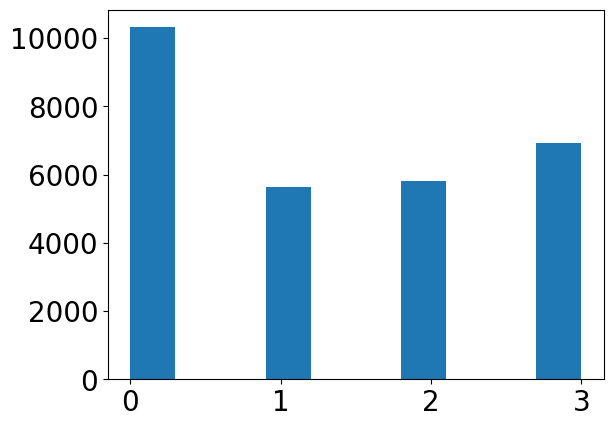

In [17]:
plt.hist(X)
plt.show()

In [18]:
#make multiple trials 
n_trials = 50
Y = np.zeros((len(X), n_trials))
for i in range(n_trials): 
    Y[:,i] = RR(X[:,None], epsilon = 2.5).squeeze()
print('Frac unperturbed', np.mean( Y[:,0] == X) )

prob of flip: 0.19759599495081878
prob of flip: 0.19759599495081878
prob of flip: 0.19759599495081878
prob of flip: 0.19759599495081878
prob of flip: 0.19759599495081878
prob of flip: 0.19759599495081878
prob of flip: 0.19759599495081878
prob of flip: 0.19759599495081878
prob of flip: 0.19759599495081878
prob of flip: 0.19759599495081878
prob of flip: 0.19759599495081878
prob of flip: 0.19759599495081878
prob of flip: 0.19759599495081878
prob of flip: 0.19759599495081878
prob of flip: 0.19759599495081878
prob of flip: 0.19759599495081878
prob of flip: 0.19759599495081878
prob of flip: 0.19759599495081878
prob of flip: 0.19759599495081878
prob of flip: 0.19759599495081878
prob of flip: 0.19759599495081878
prob of flip: 0.19759599495081878
prob of flip: 0.19759599495081878
prob of flip: 0.19759599495081878
prob of flip: 0.19759599495081878
prob of flip: 0.19759599495081878
prob of flip: 0.19759599495081878
prob of flip: 0.19759599495081878
prob of flip: 0.19759599495081878
prob of flip: 

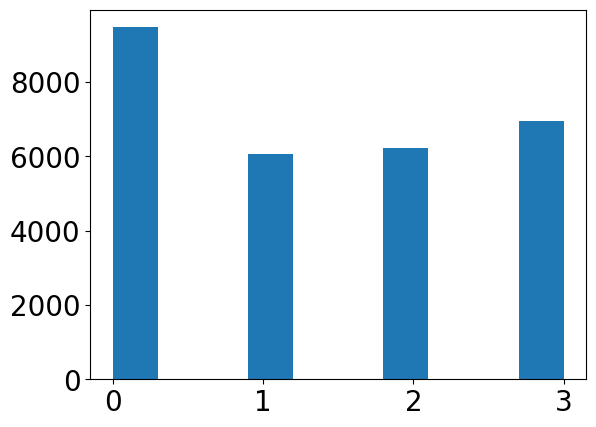

In [19]:
plt.hist(Y[:,0])
plt.show()

# Find groups $\mathcal{G}$

In [20]:
T_locs = np.concatenate((T[:,T_cols == 'KM_LAT'], T[:,T_cols == 'KM_LON']), axis = 1)
T_locs.shape

(28698, 2)

In [21]:
R = 20 #km
Dx = T_locs[:,0][:,None] - T_locs[:,0][:,None].T
Dy = T_locs[:,1][:,None] - T_locs[:,1][:,None].T
Distmat = np.sqrt(Dx**2 + Dy**2)
N = Distmat <= R #adjacency matrix of group graph

In [22]:
#neighbor statistics 
n_neighbs = np.sum(N, axis = 1)
print(n_neighbs.max())
print(n_neighbs.min())
print(n_neighbs.mean())
print(np.median(n_neighbs))
print(np.std(n_neighbs))

3280
1
976.8793644156387
771.0
860.8677639871621


In [23]:
#For each individual, 
#For each noisy sample, 
#Get predictions
feat = 'TOTAL_CHARGES' #feature used to make NN prediction 
T_feat = T[:,T_cols == feat]
Dmat = np.abs(T_feat - T_feat.T) #distance matrix of feature between individuals
assert Dmat.shape[0] == Dmat.shape[1]

# Generate permutations for several trials and radii

In [28]:
r_vals = np.asarray([0., 10., 20., 30., 40., 50., 60., 70., 80.])
n_trials = 10        
alpha = 4

print('get reference perms')
sig0s = {}
delts = {}
for R in tqdm(r_vals): 
    sig0, Deltas = get_sig0(T_locs, R, Distmat, Distmat)
    sig0s[R] = sig0
    delts[R] = Deltas

print('sample perms')
for trial in tqdm(range(n_trials)): 
    for R in r_vals:
        Deltas = delts[R]
        sig0 = sig0s[R]
        labels_pshuff, sig_full, sig0_full = shuffle_dataset_II(Y[:,0], alpha, 
                                                                Deltas, sig0)
        np.save('./permutations_trials/sigmasamp_R{0:.3f}_n{1:n}'\
                .format(R, trial), sig_full)
        
    np.save('./permutations_trials/sigma0_R{0:.3f}_n{1:n}'\
                .format(R, trial), sig0_full)

sample perms


<ipython-input-28-e88c3cf5d4d4>:14: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for trial in tqdm(range(n_trials)):


  0%|          | 0/10 [00:00<?, ?it/s]

In [35]:
# r_vals = np.linspace(0, 1000, 5)
r_vals = np.asarray([0., 10., 20., 30., 40., 50., 60., 70., 80.])
n_trials = 10  

shuff_idx = np.arange(Y.shape[0])
np.random.shuffle(shuff_idx)
Y_shuff = Y[shuff_idx, :]

Rcorr = 20 #attack radius
K = 20 

alpha = 4

def print_stats(vuln_k, vuln_grp): 
    print("Num KNN'd:", len(vuln_k))
    print("Num Grp'd:", len(vuln_grp))
    gap = len(vuln_k) - np.in1d(vuln_k, vuln_grp).sum() #number KNN'd but not GRP'd
    print("Num KNN'd not Grp'd:", gap)
  
#key is radius, value is (vuln_k_*, vuln_grp_*)


R = 0.01 #Doesn't matter -- just for running LDP and uniform shuff, which only care abt R_corr

print("getting result for just LDP...")
vuln_k_LDP, vuln_grp_LDP = k_vs_grp_attack(X, Y, Dmat, Distmat, 
                                                   R, Rcorr, K = K, t = 0.9)
    
print("getting result for uniform shuffling...")
vuln_k_shuff, vuln_grp_shuff = k_vs_grp_attack(X, Y_shuff, Dmat, Distmat, 
                                                   R, Rcorr, K = K, t = 0.9)

n_trials = 10
vuln_pshuff_trials = np.zeros((len(r_vals), n_trials))
for trial in tqdm(range(n_trials)): 
    vuln_pshuff = {}
    for R in r_vals: 
        sig0_full = np.load('./permutations_trials/sigma0_R{0:.3f}.npy'\
                .format(R, trial))
        sig_full = np.load('./permutations_trials/sigmasamp_R{0:.3f}_n{1:n}.npy'\
                .format(R, trial))

        Y_pshuff = Y[sig_full[np.argsort(sig0_full)], :]

        vuln_k_pshuff, vuln_grp_pshuff = k_vs_grp_attack(X, Y_pshuff, Dmat, Distmat, 
                                                       R, Rcorr, K = K, t = 0.9)


        vuln_pshuff_trials[r_vals == R, trial] = len(vuln_k_pshuff) / len(T) #fraction inferred
        


get reference perms


<ipython-input-35-13cdf8cc2e9c>:43: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for trial in tqdm(range(n_trials)):


  0%|          | 0/10 [00:00<?, ?it/s]

In [36]:
attack_mn = vuln_pshuff_trials.mean(axis = 1)
attack_st = vuln_pshuff_trials.std(axis = 1)

LDP_attack = len(vuln_k_LDP) / len(T)
shuff_attack = len(vuln_k_shuff) / len(T)

In [39]:
np.save('./Texas_attack_mean_trials.npy', attack_mn)
np.save('./Texas_attack_std_trials.npy', attack_st)
np.save('./Texas_radii_trials.npy', r_vals)
np.save('./Texas_attack_LDP_trials.npy', np.ones(len(r_vals)) * LDP_attack)
np.save('./Texas_attack_shuff_trials.npy', np.ones(len(r_vals)) * shuff_attack)

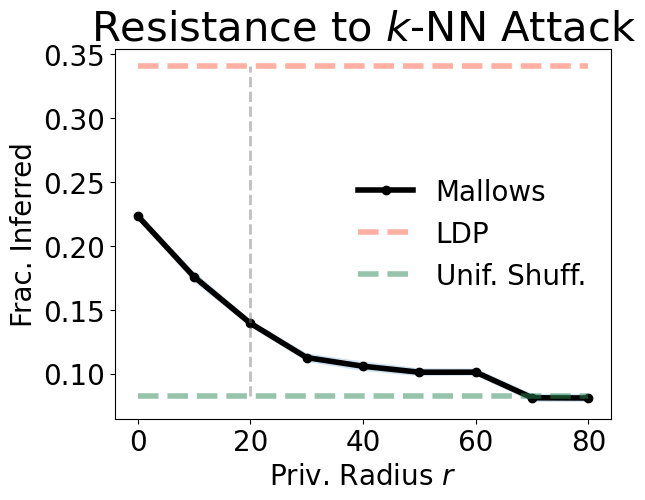

In [37]:
plt.plot(r_vals, attack_mn, '-o', label = "Mallows", color = 'black')
plt.fill_between(r_vals, attack_mn + attack_st, attack_mn - attack_st, alpha = 0.2)
plt.plot(r_vals, np.ones(len(r_vals)) * LDP_attack, '--', label = "LDP", alpha = 0.5, color = 'tomato')
plt.plot(r_vals, np.ones(len(r_vals)) * shuff_attack, '--', label = "Unif. Shuff.", alpha = 0.5, color = 'seagreen')
plt.plot(np.ones(10)*Rcorr, np.linspace(shuff_attack, LDP_attack, 10), '--', 
         alpha = 0.5, color = 'gray', linewidth = 2)
plt.legend(loc = 'right')
plt.title('Resistance to $k$-NN Attack')
plt.xlabel('Priv. Radius $r$')
plt.ylabel('Frac. Inferred')
plt.show()

# Get TV utility over trials 

In [43]:
#Get LDP utility:
set_plot_defaults()
r_vals = np.asarray([0., 10., 20., 30., 40., 50., 60., 70., 80.])
n_trials = 10  

#Get LDP utility: 
R_calib = 20
cv = 3
msl = 100

lr = 0.1

LDP_TV = get_calibration_TVD(Y[:,0], X, Distmat, R_calib, T_locs, cv = cv, 
                        base_clf=GBC(min_samples_leaf = msl, learning_rate = lr)).mean()

print('LDP TV:', LDP_TV)

Y_unishuffle_idx = np.arange(len(Y[:,0]))
np.random.shuffle(Y_unishuffle_idx)
Y_unishuffle = Y[Y_unishuffle_idx,0]

Unif_shuff_TV = get_calibration_TVD(Y_unishuffle, X, Distmat, R_calib, T_locs, cv = cv, 
                        base_clf=GBC(min_samples_leaf = msl, learning_rate = lr)).mean()

print('Unif. shuff. TV:', Unif_shuff_TV)

oblivious = np.ones((len(X), 4)) / 4
oblivious_TV = get_TVD(oblivious, Distmat, R_calib, T_locs, X).mean()
print('Oblivious TV:', oblivious_TV)

r_shuff_TV = np.zeros((len(r_vals), n_trials))

for trial in tqdm(range(n_trials)): 
    for r in r_vals: 
        ref_perm = np.load('./permutations_trials/sigma0_R{0:.3f}.npy'\
                .format(r))
        samp_perm = np.load('./permutations_trials/sigmasamp_R{0:.3f}_n{1:n}.npy'\
                .format(r, trial))
        Y_shuffle = Y[samp_perm[np.argsort(ref_perm)], 0]

        r_shuff_TV[r_vals == r, trial] = get_calibration_TVD(Y_shuffle, X, Distmat, R_calib, T_locs, cv = cv, 
                            base_clf=GBC(min_samples_leaf = msl, learning_rate = lr)).mean()
    

LDP TV: 0.11054783220383387
Unif. shuff. TV: 0.18981278474103286
Oblivious TV: 0.21881090718958396


<ipython-input-43-72a190801855>:33: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for trial in tqdm(range(n_trials)):


  0%|          | 0/10 [00:00<?, ?it/s]

In [48]:
TV_shuff_mn = (r_shuff_TV/oblivious_TV).mean(axis = 1)
TV_shuff_st = (r_shuff_TV/oblivious_TV).std(axis = 1)

In [50]:
np.save('./Texas_utility_mean_trials.npy', TV_shuff_mn)
np.save('./Texas_utility_std_trials.npy', TV_shuff_st)
np.save('./Texas_radii_trials.npy', r_vals)
np.save('./Texas_utility_LDP_trials.npy', np.ones(len(r_vals)) * LDP_TV / oblivious_TV)
np.save('./Texas_utility_shuff_trials.npy', np.ones(len(r_vals)) * Unif_shuff_TV / oblivious_TV)

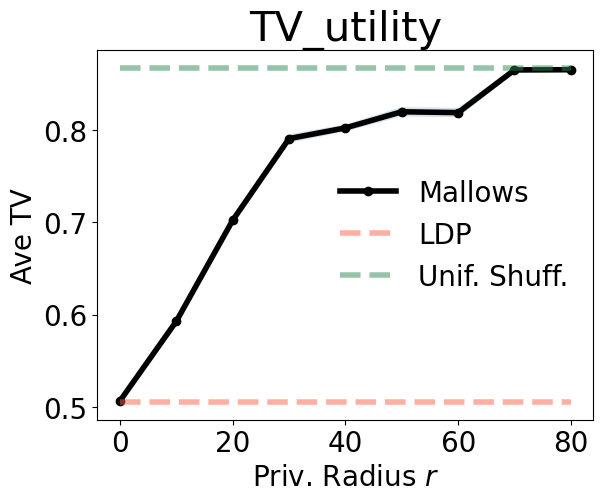

In [49]:
plt.plot(r_vals, TV_shuff_mn, '-o', label = "Mallows", color = 'black')
plt.fill_between(r_vals, TV_shuff_mn + TV_shuff_st, TV_shuff_mn - TV_shuff_st, alpha = 0.2)
plt.plot(r_vals, np.ones(len(r_vals)) * LDP_TV / oblivious_TV, '--', label = "LDP", alpha = 0.5, color = 'tomato')
plt.plot(r_vals, np.ones(len(r_vals)) * Unif_shuff_TV / oblivious_TV, '--', label = "Unif. Shuff.", alpha = 0.5, color = 'seagreen')
plt.legend(loc = 'right')
plt.title('TV_utility')
plt.xlabel('Priv. Radius $r$')
plt.ylabel('Ave TV')
plt.show()